### Medium Term Model  
Due to its temporal complexity, Hydro Power Decision Making is typically split up into multiple problems. We explore a seasonal model with a timeframe of 6-18 months. We try to answer the question when to use water for power production governed by price and inflow variations.  
A key uncertainty of hydropower is inflow. Yearly variations of total inflow are around 30%.

The goal of this model is to be used input in the short term model for decision making. Therefore, it is simply a tool to improve the decision making we make in the short term.  

#### Water Value Cuts

The way this model is integrated into the short-term is by a Water Value Function $V(l)$. In the objective of the short term model we include 

$$
- \sum\limits_{r \in \mathcal{R}}V(l_{r,t}) - V(l_{r,t+1})
$$

If the reservoir is less full at $t+1$ than at $t$, the piece-wise linear and concave function penalizes the objective. 


In [2]:
using JuMP
using CPLEX
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using SDDP
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end

includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

The approach is to generate approximations to the Water Value Function (which is already difficult to define in the first place).

* Solve the medium-term model
* Obtain dual solution $\pi_r$ corresponding to the balance constraints of the reservoirs -> Gradient for Water Value
* Obtain objective function value $\varphi_M(l)$
* Form the cut coefficients for each cut $c$ from both informations for different reservoir levels.

Mathematically speaking, we are trying to find cuts of the following form:

$$
\alpha_r^c \leq \varphi_M^c(l^c_r) - \pi_r^c \cdot (l_{r}^c - l_{r,t+1})
$$


### Coefficients and Parameters

In [3]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
R, K, J = read_data(filepath_Ljungan)
print(R[1]) 

j = J[1]
O = OtherParticipant(J, j , R)[1]
K_j = [j.plants[1]]
K_O = [O.plants[1]]
pj = j.participationrate
pO = O.participationrate


println("Participation rate $(j.name): \n ", pj)
println("Participation rate $(O.name): \n ", pO)
println("K_O : $(K_O) and spillage $(K_O[1].spillreference),\nK_j : $(K_j) and spillage $(K_j[1].spillreference)")

T = 7 # Days in a Week
W = 52 # Weeks in time horizon (26-78, depending on the day we are looking at)

FlasjonParticipation rate Sydkraft: 
 ________________________________
Holsmjon | 0.0     
Flasjon  | 1.84    

Participation rate Other: 
 ________________________________
Holsmjon | 2.68    
Flasjon  | 2.68    



K_O : HydropowerPlant[Parteboda] and spillage 140.0,
K_j : HydropowerPlant[Flasjo] and spillage 58.0


52

### Price & Inflows

23.0


52


NamedTuple{(:in, :pr), Tuple{Float64, Float64}}[(in = 1.0, pr = 12.0), (in = 1.0, pr = 18.0), (in = 4.0, pr = 12.0), (in = 4.0, pr = 18.0), (in = 6.0, pr = 12.0), (in = 6.0, pr = 18.0)]


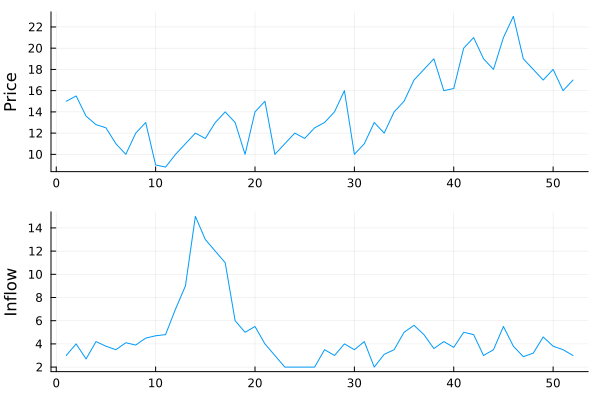

In [4]:
price = [15.0, 15.5, 13.6, 12.8, 12.5, 11.0, 10.0, 12.0, 13.0, 9.0, 8.8, 10.0, 11.0, 12.0, 11.5, 13.0, 14.0, 13.0, 10.0, 14.0, 15.0, 10.0, 11.0, 12.0, 11.5, 12.5, 13.0, 14.0, 16.0, 10.0, 11.0, 13.0, 12.0, 14.0, 15.0, 17.0, 18.0, 19.0, 16.0, 16.2, 20.0, 21.0, 19.0, 18.0, 21.0, 23.0, 19.0, 18.0, 17.0, 18.0, 16.0, 17.0]
inflow = [3.0, 4.0, 2.7, 4.2, 3.8, 3.5, 4.1, 3.9, 4.5, 4.7, 4.8, 7.0, 9.0, 15.0, 13.0, 12.0, 11.0, 6.0, 5.0, 5.5, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.5, 3.0, 4.0, 3.5, 4.2, 2.0, 3.1, 3.5, 5.0, 5.6, 4.8, 3.6, 4.2, 3.7, 5.0, 4.8, 3.0, 3.5, 5.5, 3.8, 2.9, 3.2, 4.6, 3.8, 3.5, 3.0] 

println(maximum(price))
println(length(inflow))
inflow_var = [-2.0, 1.0, 3.0]
price_var = [-3.0, 3.0]
P  = [0.2, 0.2, 0.1, 0.2, 0.2, 0.1] 
Omega = Dict(t => [(in = inflow[t] + el_i, pr = price[t] + el_p) for el_i in inflow_var for el_p in price_var] for t in 1:52)
println(Omega[1])
Plots.plot(
    Plots.plot(price, ylabel = "Price"),
    Plots.plot(inflow, ylabel = "Inflow"),
    layout = (2,1),
    legend = false,
    show = true,
)

In [5]:
function subproblem_builder_medium(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, initial_value = r.currentvolume, SDDP.State)
    # Control Variables
    @variable(subproblem, Q[r = R] >= 0)
    @variable(subproblem, s[r = R] >= 0)
    @variable(subproblem, w[k = K] <= k.spillreference * k.equivalent)
    # Random Variables
    @variable(subproblem, f[r = R])
    # Transition Function 
    @constraint(subproblem, balance[r = R],  l[r].out == l[r].in - Q[r] +f[r] - s[r])
    # Constraints
    # @constraint(subproblem, balance_limits[r = R], lmin[node] <=  l[r].out <= lmax[node])
    @constraint(subproblem, production[k = K], w[k] <= sum(Q[r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
    # Objective
    # Parameterize Uncertainty
    SDDP.parameterize(subproblem, Omega[node], P) do om
        for r in R
            JuMP.fix(f[r], om.in)
        end
        @stageobjective(subproblem, om.pr * sum(w[k] for k in K))
    end
end


subproblem_builder_medium (generic function with 1 method)

In [6]:
println("Upper Bound: ", sum(r.currentvolume * maximum(price) * sum(k.equivalent for k in K) for r in R))

graph = SDDP.LinearGraph(52)

model_medium = SDDP.PolicyGraph(
    subproblem_builder_medium,
    graph;
    sense = :Max,
    upper_bound = sum(r.currentvolume * maximum(price) * sum(k.equivalent for k in K) for r in R),
    optimizer = CPLEX.Optimizer
)

Upper Bound: 291088.00000000006


A policy graph with 52 nodes.
 Node indices: 1, ..., 52


In [7]:
SDDP.train(model_medium; iteration_limit = 100)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------


problem
  nodes           : 52
  state variables : 2
  scenarios       : 2.90981e+40
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : 

SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [24, 24]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]
  AffExpr in MOI.LessThan{Float64}        : [13, 13]
  VariableRef in MOI.GreaterThan{Float64} : [6, 7]
  VariableRef in MOI.LessThan{Float64}    : [16, 16]


numerical stability report
  matrix range     [7e-02, 1e+00]
  objective range  [1e+00, 3e+01]
  bounds range     [7e+00, 3e+05]
  rhs range        [0e+00, 0e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   3.580495e+04  3.012148e+05  5.998000e+00       364   1
         2   8.053354e+04  3.001004e+05  7.135000e+00      5928   1


        30   2.324164e+05  2.352827e+05  8.163000e+00     16120   1


        36   2.292563e+05  2.352624e+05  9.166000e+00     23504   1


       100   2.425420e+05  2.349987e+05  1.298800e+01     62400   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 1.298800e+01
total solves   : 62400
best bound     :  2.349987e+05
simulation ci  :  2.306369e+05 ± 5.141538e+03
numeric issues : 0
-------------------------------------------------------------------



### Simulations

Test Plot for one Replication

[2006.0, 1903.0, 1798.7, 1800.9, 1747.7, 1752.2, 1754.3, 1756.2, 1700.7, 1706.4, 1712.2, 1722.2, 1729.2, 1742.2, 1756.2, 1771.2, 1678.2, 1682.2, 1688.2, 1696.7, 1698.7, 1704.7, 1707.7, 1649.7, 1649.7, 1594.7, 1541.2, 1547.2, 1554.2, 1558.7, 1563.9, 1563.9, 1565.0, 1566.5, 1569.5, 1515.1, 1417.8999999999999, 1314.4999999999998, 1321.6999999999998, 1223.3999999999999, 1121.3999999999999, 1022.1999999999998, 923.1999999999998, 822.6999999999998, 721.1999999999998, 622.9999999999998, 518.8999999999997, 415.0999999999998, 307.6999999999998, 204.49999999999983, 101.00000000000028, 0.0]
[0.0, 17.98, 17.98, 0.0, 17.98, 0.0, 0.0, 0.0, 17.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.98, 0.0, 17.98, 17.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.98, 17.98, 17.98, 0.0, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98, 17.98]


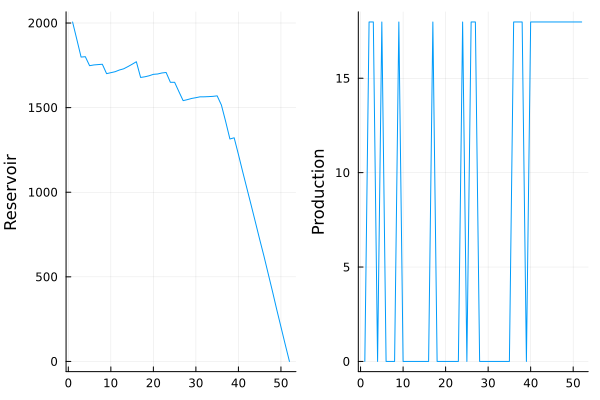

In [8]:
n = 100
simulations = SDDP.simulate(model_medium, n, [:l, :w]);

l_sim = [sim[:l][R[1]].out for sim in simulations[1]]
w_sim = [sim[:w][K[1]] for sim in simulations[1]]

println(l_sim)
println(w_sim)


Plots.plot(
    Plots.plot(l_sim, ylabel = "Reservoir"),
    Plots.plot(w_sim, ylabel = "Production"),
    legend = false,
    show = true,
)

### Spaghetti Plot

In [9]:
plot = SDDP.SpaghettiPlot(simulations)
SDDP.add_spaghetti(plot; title = "Reservoir") do sim
    return sum(sim[:l][r].out for r in R)
end
SDDP.add_spaghetti(plot; title = "Production") do sim
    return sum(sim[:w][k] for k in K)
end
SDDP.plot(
    plot,
    "spaghetti_plot.html";
    # We need this to build the documentation. Set to true if running locally.
    open = true,
)

### Obtain Water Values 

We trained the model and simulated it for different uncertainty realizations.
Next we obtain the Water Values for different initial conditions. How does the water value differ?

In [10]:
V = SDDP.ValueFunction(model_medium; node = 1)
cost, price = SDDP.evaluate(V, Dict(Symbol("l[$(r)]") => r.maxvolume for r in R))
println(cost)

291088.00000000006


Here we get the objective value and the gradient for both reservoirs. The gradient is positive, as an increase in reservoir capacity leads to an improvement in the objective function.  
We can plot the value function for multiple initial reservoir levels:

LinRange{Float64}(0.0, 2000.0, 100)LinRange{Float64}(0.0, 800.0, 100)


FlasjonHolsmjon


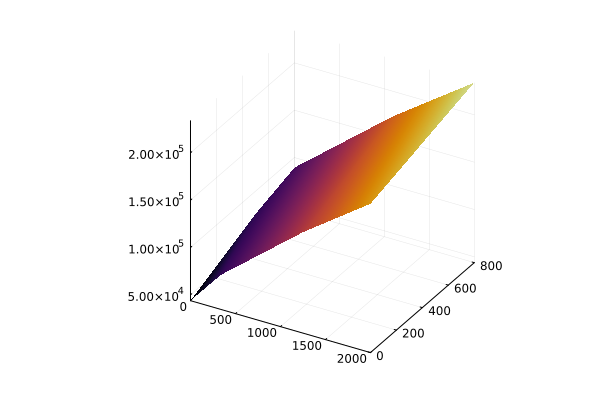

In [11]:
bounds_1 = LinRange(0.0, R[1].currentvolume, 100)
bounds_2 = LinRange(0.0, R[2].currentvolume, 100)
println(bounds_1, bounds_2)
println(R[1], R[2])
f(x, y) = SDDP.evaluate(V, (Symbol("l[Holsmjon]") => y, Symbol("l[Flasjon]") => x))[1]
surface(bounds_1, bounds_2, f, legend = false)

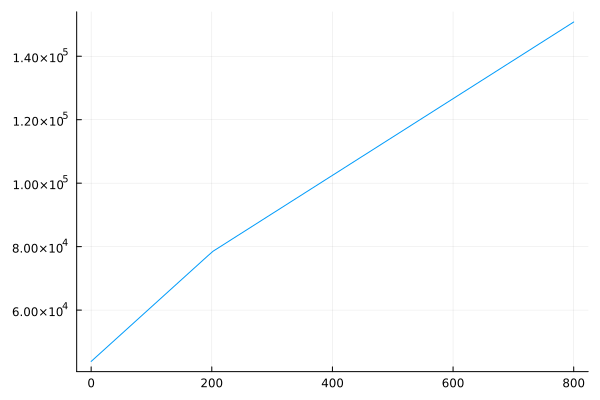

In [12]:
g(x) = SDDP.evaluate(V, (Symbol("l[Holsmjon]") => x, Symbol("l[Flasjon]") => x))[1]

Plots.plot(bounds_2, g, legend=false)

## To-Do

* Use real water data and real price data (average)
* Get average inflow values and confidence intervals for inflow variations (hopefully gaussian distribution)

### Real Water Data and Average Historical Prices

* Load in historical inflow data from csv into Dataframe.  
* Determine key scenarios for inflow (low, medium high, average low/high, etc..)
* Obtain average price scenarios (starting with one, at max 3, let's see what is possible)

In [13]:
df_inflow = DataFrame(CSV.File("Inflow Forecasting\\Data\\Inflow\\Data from Flasjoen and Holmsjoen.csv"))
df_inflow_average = DataFrame(CSV.File("Inflow Forecasting\\Data\\Inflow\\CleanInflowData.csv"))
replace!(df_inflow_average."Mean Inflow Flasjon", missing => (27.332 + 31.008)/2 )
coalesce.(df_inflow, 0.0)
println(df_inflow_average[180:200,"Mean Inflow Flasjon"])

Union{Missing, Float64}[34.272777777777776, 35.38777777777778, 38.562777777777775, 36.617222222222225, 33.157777777777774, 30.52833333333334, 27.395555555555557, 27.33166666666667, 29.17, 31.00764705882353, 30.615882352941178, 28.573529411764703, 31.68823529411765, 30.63294117647058, 29.354117647058818, 30.135294117647057, 25.094117647058823, 23.979411764705887, 24.71058823529412, 24.09647058823529, 20.75764705882353]


#### Transform the average daily inflow values into average weekly inflow vales

We currently have an array of length 366 (??? Maybe remove last column.)  
We would like to have an array of 52 values, which contain the weekly average values of inflow.  

* Select the 7 days corresponding to each of the 52 weeks
* Calculate the average value (sum and divide by seven) and save it for each week

[8.99484126984127, 8.683968253968255, 8.68984126984127, 7.513730158730158, 7.728174603174604, 7.24531746031746, 7.00468253968254, 6.876746031746031, 6.360079365079364, 6.031031746031745, 5.902142857142857, 6.165793650793652, 9.216507936507938, 8.008333333333335, 9.325238095238095, 17.13373015873016, 40.21999999999999, 53.80285714285714, 82.98722222222223, 98.49873015873015, 112.50801587301588, 84.61992063492063, 74.7252380952381, 58.319761904761904, 48.35952380952381, 35.88650793650793, 30.7440289449113, 29.442016806722684, 23.854537815126047, 23.41243697478992, 25.10596638655462, 25.747478991596644, 24.738823529411768, 23.316386554621854, 20.7081512605042, 22.798319327731097, 19.889327731092436, 21.326890756302525, 21.697058823529414, 23.184285714285718, 23.51100840336134, 20.970336134453785, 21.543697478991596, 22.366806722689073, 17.676386554621846, 15.918823529411766, 13.451764705882354, 12.930252100840338, 11.63327731092437, 10.725378151260502, 10.97546218487395, 9.546470588235293

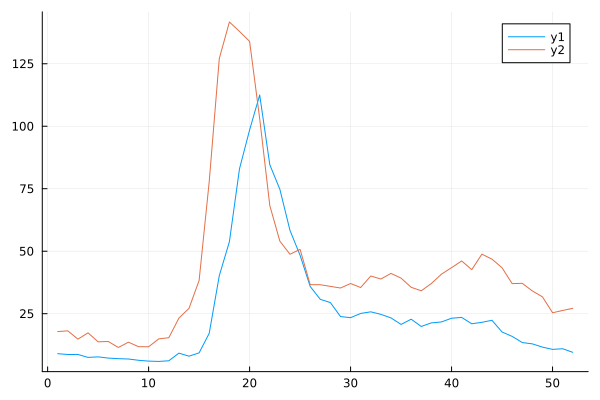

In [14]:
Weekly_Inflow_Flasjon = [sum(df_inflow_average[7*(i-1)+1:7*i, "Mean Inflow Flasjon"])./7 for i in 1:52]
Weekly_Inflow_Holmsjon = [sum(df_inflow_average[7*(i-1)+1:7*i, "Mean Inflow Holmsjon"])./7 for i in 1:52]
println(Weekly_Inflow_Flasjon)
println(Weekly_Inflow_Holmsjon)

Plots.plot(1:52, Weekly_Inflow_Flasjon, show=true)
Plots.plot!(1:52, Weekly_Inflow_Holmsjon)

In [15]:
df_inflow.CalendarWeek = Dates.week.(df_inflow.Date)
df_inflow[!, "Flasjon Inflow"] = coalesce.(df_inflow[!, "Flasjon Inflow"], 0)
gd_inflow = groupby(df_inflow[! ,["Holmsjon Inflow", "Flasjon Inflow", "CalendarWeek"]], :CalendarWeek)
ColumnReservoir = Dict{Reservoir, String}(R[1] => "Flasjon Inflow", R[2] => "Holmsjon Inflow")
WeeklyInflowDistribution = Dict{Reservoir, Any}()
WeeklyInflowDistribution[R[2]] = Normal{Float64}[fit_mle(Normal{Float64}, g[!,ColumnReservoir[R[2]]]) for g in gd_inflow]
WeeklyInflowDistribution[R[1]] = Normal{Float64}[fit_mle(Normal{Float64}, g[!,ColumnReservoir[R[1]]]) for g in gd_inflow]

println("Distribution: ", WeeklyInflowDistribution[R[1]])
InflowScenarios = Dict(R[1] => [rand(WeeklyInflowDistribution[R[1]][i], 3) for i in eachindex(WeeklyInflowDistribution[R[1]])], 
                       R[2] => [rand(WeeklyInflowDistribution[R[2]][i], 3) for i in eachindex(WeeklyInflowDistribution[R[2]])])

println(InflowScenarios[R[1]])


Distribution: 

Normal{Float64}[Normal{Float64}(μ=8.690317460317459, σ=3.2186968516821333), Normal{Float64}(μ=8.863492063492066, σ=4.189418703750419), Normal{Float64}(μ=8.556428571428572, σ=3.302169191892215), Normal{Float64}(μ=7.628888888888889, σ=3.20663875401727), Normal{Float64}(μ=7.671825396825395, σ=3.1988133714530385), Normal{Float64}(μ=6.973333333333337, σ=2.9380689587464093), Normal{Float64}(μ=7.1106349206349195, σ=2.6985442124814347), Normal{Float64}(μ=6.856428571428575, σ=2.85263411111241), Normal{Float64}(μ=6.208809523809523, σ=2.4555924533709073), Normal{Float64}(μ=6.156190476190479, σ=2.2513843561849622), Normal{Float64}(μ=6.031904761904759, σ=2.158343616186468), Normal{Float64}(μ=6.403968253968255, σ=3.914162336010476), Normal{Float64}(μ=9.39880952380952, σ=12.061271656819274), Normal{Float64}(μ=7.949285714285715, σ=6.604329409570165), Normal{Float64}(μ=9.510793650793651, σ=6.805202678620421), Normal{Float64}(μ=18.245476190476186, σ=19.44089559661898), Normal{Float64}(μ=36.1730952380952

[[9.60100481392548, 7.026468849366938, 9.277881003551173], [4.1948167339519, 3.1491026566251925, 7.765570939035869], [9.20980655104306, 10.102979597333558, 5.978850269507538], [13.0591412212064, 2.2983845235360696, 6.303580455041787], [6.085314029084498, 8.793830654338578, 12.734211325436897], [7.344410196368088, 7.475928682663053, 6.5146170825370655], [8.945879202074764, 5.574970601621764, 2.0446673017404158], [1.3429122128539388, 5.206844989069834, 5.102522470028303], [8.23252368126985, 3.27487490362944, 6.927433981855834], [3.026251233720934, 6.5194231811366565, 3.23902956087198], [3.3819953704246783, 4.937324427382993, 7.2330160981250415], [3.642644049596353, 8.575872449972161, 3.1646941164570266], [-0.7452244640128174, -3.0789087459020803, 13.08431851283139], [22.4621088259852, 9.857224306573922, -4.475656688954696], [11.036919132823373, 0.6485124885697008, 24.412620996808663], [-0.2274537946732485, 26.828783720640743, 13.860577773249378], [31.068791885970434, 37.42642500662932, 4

#### Average Daily Prices 

* Turn Hourly Prices into average daily prices

In [16]:
function prepare_pricedata(filepath_prices)
    price_data = CSV.read(filepath_prices, DataFrame)
    price_data = coalesce.(price_data, 46.79)
    price_data.Average = sum.(eachrow(price_data[:, 2:end]))/24
    rename!(price_data, :Column1 => :Date)
    price_data.season = get_season.(month.(price_data.Date))
    price_data.Weekday = dayofweek.(price_data.Date)
    price_data.Weekday = get_weekend.(price_data.Weekday)
    price_data.CalendarWeek = Dates.week.(price_data.Date)
    return price_data
end

function get_season(month::Int64)
    if month in 3:4  
        return "Spring"
    elseif month in 5:8  
        return "Summer"
    elseif month in 9:11  
        return "Autumn"
    else  
        return "Winter"
    end
end

function get_weekend(weekday::Int64)
    if weekday in 1:5
        return "Weekday"
    else
        return "Weekend"
    end
end

df_prices = prepare_pricedata("Inflow Forecasting\\Data\\Spot Prices\\prices_df.csv")


Row,Date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Average,season,Weekday,CalendarWeek
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String,String,Int64
1,2020-12-15,17.57,17.57,16.92,16.88,18.95,20.39,22.31,24.59,31.41,31.49,31.62,30.52,35.9,38.1,40.08,43.08,37.32,51.13,47.54,40.77,35.2,28.45,23.67,21.86,30.1383,Winter,Weekday,51
2,2020-12-16,20.48,19.32,19.0,19.02,20.19,21.98,22.71,32.71,48.37,43.68,42.01,37.92,36.56,36.42,39.16,46.54,46.4,39.41,35.78,24.74,22.78,22.15,21.48,20.12,30.7887,Winter,Weekday,51
3,2020-12-17,19.03,17.93,17.53,17.28,17.97,20.0,22.09,23.64,26.79,25.28,24.43,24.3,23.67,23.99,23.97,25.06,25.38,26.07,24.22,23.16,22.19,21.97,20.76,18.99,22.3208,Winter,Weekday,51
4,2020-12-18,16.96,16.65,16.17,16.3,17.3,19.39,19.99,22.43,23.74,23.96,22.82,22.5,22.44,22.23,22.42,22.91,23.11,23.83,22.59,21.01,19.43,19.04,17.82,15.92,20.4567,Winter,Weekday,51
5,2020-12-19,16.48,15.98,15.47,15.31,15.3,15.52,15.87,15.92,16.48,17.01,17.36,17.47,17.27,17.29,17.33,17.54,17.96,18.39,17.77,17.03,15.92,15.69,15.22,13.65,16.4679,Winter,Weekend,51
6,2020-12-20,13.0,12.04,11.79,11.65,11.79,11.98,12.53,12.7,13.25,14.28,15.37,15.94,15.83,15.37,15.98,16.84,17.09,17.29,17.06,16.3,15.32,15.23,14.65,13.02,14.4292,Winter,Weekend,51
7,2020-12-21,11.9,11.2,11.5,11.73,12.81,14.37,16.67,19.74,20.6,19.92,19.32,19.39,19.44,19.2,19.45,20.65,20.55,20.35,19.49,18.03,16.17,14.47,13.18,8.66,16.6163,Winter,Weekday,52
8,2020-12-22,7.15,5.51,4.77,4.44,4.84,7.73,12.82,15.97,17.87,18.0,18.09,18.01,18.01,17.57,18.08,18.62,19.67,19.87,19.79,18.01,16.88,16.05,15.05,13.71,14.4379,Winter,Weekday,52
9,2020-12-23,13.38,13.1,12.9,12.93,13.14,14.72,15.99,18.59,19.21,19.51,18.97,19.33,19.55,19.4,19.66,19.96,20.56,21.79,20.77,18.95,17.82,16.94,16.16,15.07,17.4333,Winter,Weekday,52


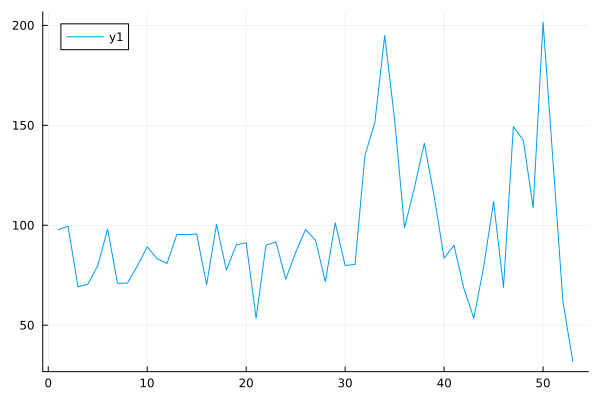

In [17]:
gd = groupby(df_prices[!,[:Average, :CalendarWeek]], :CalendarWeek)
gd[1]
AveragePrice = []
for g in gd
    avg = sum(g.Average)/nrow(g)
    push!(AveragePrice, avg)
end

Plots.plot(AveragePrice)

### Fit Distribution to Average Prices

The Average Prices are a slightly unrealisitic representation. They ignore how much the prices can vary at certain times. Therefore, we derive a distribution (normally distributed) for every week of the year, and derive price scenarios by sampling from that distribution. 

[[118.562291006424, 199.98959093861407, 129.2763998688032], [90.62892976050796, 44.81857637424411, 22.793133861675457], [102.989081574568, 60.76831506895941, 48.63439286408516], [82.62637014953657, 83.80699045038443, 15.599590484715467], [64.20124344092793, 159.53488041213453, 81.25637665136081], [83.00528550099979, 29.707875721658628, 127.9823918866723], [104.62942147730966, 60.00672966952903, 169.07177955317925], [70.18166201851439, 111.4615612866862, 40.6181332716901], [110.37328349512303, 160.5610313052516, 39.13954542502516], [53.81142394551251, 6.303947765092468, 161.0975445906641], [33.0215783189702, 93.37068553109488, 46.775511500980826], [83.82672542059278, 71.48920356041299, 75.5115546816507], [133.33590826014355, 98.57712999775138, 66.18539890269241], [85.22040737352135, 216.59399969659665, 138.87933830271933], [47.35020355233003, 51.00741793288581, 105.66746438891347], [128.0324555218589, 84.56776180746269, 39.53047319656354], [138.94457688709042, 77.1907147537269, 59.10559

NamedTuple{(:price, :inflow), Tuple{Vector{Float64}, Float64}}[(price = [118.562291006424, 90.62892976050796, 102.989081574568, 82.62637014953657, 64.20124344092793, 83.00528550099979, 104.62942147730966, 70.18166201851439, 110.37328349512303, 53.81142394551251, 33.0215783189702, 83.82672542059278, 133.33590826014355, 85.22040737352135, 47.35020355233003, 128.0324555218589, 138.94457688709042, 33.32458267005013, 14.57259362261321, 227.80635701495038, 47.42511935806268, 134.99312972577502, 109.28024858424837, 137.32911274333873, 123.06464249074395, 43.0743976922606, 127.01730437578343, 135.66874651676198, 109.66510879126464, 93.10856462745522, 74.69786330359263, 164.44835146142805, 15.675848101429693, 281.7066131805215, 158.0701248764935, 116.56309223538334, 243.65499631107545, 173.67262853621858, 70.25191696870134, 77.872768988251, 93.29863183259015, 49.75859723908558, 16.977365003622765, 105.83213035151059, 59.7775087058534, 50.323767823563614, 120.29295646545448, 202.4559973598681, 1

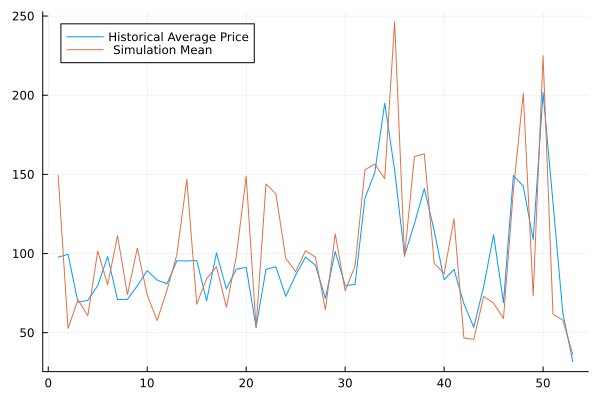

In [18]:
gd = groupby(df_prices[!,[:Average, :CalendarWeek]], :CalendarWeek)
WeeklyPriceDistribution = Rayleigh{Float64}[fit_mle(Rayleigh{Float64}, g[!,:Average]) for g in gd]
WeeklyPriceScenarios = [rand(WeeklyPriceDistribution[i], 3) for i in eachindex(WeeklyPriceDistribution)]
println(WeeklyPriceScenarios)
Omega = [(price = [WeeklyPriceScenarios[i][j] for i in 1:53], inflow = 0.3) for j in 1:3]
println(Omega)
# Plots.plot(1:53, [Omega[i][1] for i in 1:53])
# Plots.plot!(1:53, [Omega[i][2] for i in 1:53])
# Plots.plot!(1:53, [Omega[i][3] for i in 1:53])
# Plots.plot!(1:53, [Omega[i][4] for i in 1:53])
# Plots.plot!(1:53, [Omega[i][5] for i in 1:53])
Plots.plot(1:53, AveragePrice, label="Historical Average Price")
Plots.plot!(1:53, [mean(WeeklyPriceScenarios[i]) for i in 1:53], label=" Simulation Mean")

### Create the Uncertainty Set

We want to have independent (simplification) uncertainty sets for each week, so

$$
    (\Omega_i, \mathbb{P}_i), \; i \in \{1,\ldots,52\} 
$$
The Uncertainty sets are made up of scenarios for each week. For an amount of scenarios N:
$$
    \Omega_i = \{(\text{inflow}_j = \ldots, \text{price}_j = \ldots), \; j \in \{1, \ldots, N\} \}, 
$$

To create these sets, we

* Create an amount of price scenarios for every week
* Create an amount of inlow scenarios for every week
* Form the cartesian product

Then we can input weekly Scenarios nodewise into the optimziation model.
The inflows to both reservoirs are not additionally independent, as their generation is already independent.  

In [19]:
scenario_count_price = 5
scenario_count_inflow = 5 # => yields 3 * 3 = 9 scenarios in total. Alternative: Patch them together beforehand
PriceScenarios = Dict(i => rand(WeeklyPriceDistribution[i], scenario_count_price) for i in eachindex(WeeklyPriceDistribution))
# InflowScenarios = Dict(R[1] => [rand(WeeklyInflowDistribution[R[1]][i], 3) for i in eachindex(WeeklyInflowDistribution[R[1]])], 
#                        R[2] => [rand(WeeklyInflowDistribution[R[2]][i], 3) for i in eachindex(WeeklyInflowDistribution[R[2]])])
InflowScenarios = Dict(i => Dict(R[1] => max.(rand(WeeklyInflowDistribution[R[1]][i], scenario_count_inflow), 0) , R[2] => max.(rand(WeeklyInflowDistribution[R[2]][i], scenario_count_inflow), 0)) for i in eachindex(WeeklyInflowDistribution[R[1]]))

println("Price Scenarios: ", PriceScenarios[1])
println("Inflow Scenarios: ", InflowScenarios[1])

"""
Create Uncertainty Sets for each stage, by having a Dict, and depending on the stage accessing a different Vector of uncertain values.
"""
function create_Ω(PriceScenarios::Dict{Int64, Vector{Float64}}, InflowScenarios::Dict{Int64, Dict{Reservoir, Vector{Float64}}}, R::Vector{Reservoir})
    Ω = Dict( i => [(price = P, inflow = Dict(R[1] =>  InflowScenarios[i][R[1]][j], R[2] => InflowScenarios[i][R[2]][j])) for P in PriceScenarios[i] for j in eachindex(InflowScenarios[i][R[1]])] for i in 1:52)
    P = Dict(i => [1/length(Ω[i]) for j in eachindex(Ω[i])] for i in 1:52)
    return Ω, P 
end

Ω, P = create_Ω(PriceScenarios, InflowScenarios, R)

CorrespDict = Dict("inflow_Flasjon" => R[1], "inflow_Holmsjon" => R[2])

println("Uncertainty Set: ", Ω[10], "length: ", length(Ω[10]) )
println("Probability Set: ", P[10] , "length: ", length(P[10]) )

Price Scenarios: [82.41993810472415, 146.21330340522977, 61.309843358737936, 12.433088129763624, 28.41053912384313]
Inflow Scenarios: 

Dict{Reservoir, Vector{Float64}}(Holsmjon => [13.873168664308277, 22.242114969261447, 11.261405974891156, 60.83423165261575, 0.0], Flasjon => [5.278061422044292, 13.368475783238468, 14.321429711211568, 13.029272902418114, 11.707628654183289])


Uncertainty Set: 

NamedTuple{(:price, :inflow), Tuple{Float64, Dict{Reservoir, Float64}}}[(price = 124.97352376696759, inflow = ________________________________
Holsmjon | 0.0     
Flasjon  | 5.167165066164232
), (price = 124.97352376696759, inflow = ________________________________
Holsmjon | 4.835708419995478
Flasjon  | 0.253186704584176
), (price = 124.97352376696759, inflow = ________________________________
Holsmjon | 29.693152612189984
Flasjon  | 3.3550391307616487
), (price = 124.97352376696759, inflow = ________________________________
Holsmjon | 7.326809945828178
Flasjon  | 2.255793020941018
), (price = 124.97352376696759, inflow = ________________________________
Holsmjon | 6.882657962465189
Flasjon  | 2.20683990146405
), (price = 38.70281831315148, inflow = ________________________________
Holsmjon | 0.0     
Flasjon  | 5.167165066164232
), (price = 38.70281831315148, inflow = ________________________________
Holsmjon | 4.835708419995478
Flasjon  | 0.253186704584176
), (price = 38.70281831315

### Solve the Medium Term Model with real Scenarios

In [20]:
function MediumTermModel(
    R::Vector{Reservoir},
    K::Vector{HydropowerPlant},
    Omega,
    P,
    Stages::Int64;
    iterations = 1000,
    stopping_rule = [SDDP.BoundStalling(10, 1)],
    printlevel = 1
)
    function subproblem_builder_medium(subproblem::Model, node::Int64)
        # State Variables
        @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, initial_value = r.currentvolume/2, SDDP.State)
        # Control Variables
        @variable(subproblem, Q[r = R] >= 0)
        @variable(subproblem, s[r = R] >= 0)
        @variable(subproblem, w[k = K] <= k.spillreference * k.equivalent)
        # Random Variables
        @variable(subproblem, f[r = R])
        # Transition Function 
        @constraint(subproblem, balance[r = R],  l[r].out == l[r].in -  Q[r] + f[r] - s[r])
        # Constraints
        # @constraint(subproblem, balance_limits[r = R], lmin[node] <=  l[r].out <= lmax[node])
        @constraint(subproblem, production[k = K], w[k] <= sum(Q[r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
        # Objective
        # Parameterize Uncertainty
        SDDP.parameterize(subproblem, Ω[node], P[node]) do om
            for r in R
                JuMP.fix(f[r], om.inflow[r])
            end
            @stageobjective(subproblem, om.price * sum(w[k] for k in K))
        end
    end

    graph = SDDP.LinearGraph(52)
    SDDP.add_edge(graph, 52 => 1, 0.5)
    model_medium = SDDP.PolicyGraph(
    subproblem_builder_medium,
    graph;
    sense = :Max,
    upper_bound = sum(r.currentvolume * 300 * sum(k.equivalent for k in filter(k -> k.reservoir in find_ds_reservoirs(r), K)) * 5 for r in R),
    optimizer = CPLEX.Optimizer)

    SDDP.train(
        model_medium;
        iteration_limit = iterations,
        stopping_rules = stopping_rule,
        print_level = printlevel)
    
    return model_medium
end

MediumTermModel (generic function with 1 method)

In [21]:
model_data = MediumTermModel(R, K, Omega, P, 52)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 52
  state variables : 2
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [24, 24]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]
  AffExpr in MOI.LessThan{Float64}        : [13, 13]
  VariableRef in MOI.GreaterThan{Float64} : [6, 6]
  VariableRef in MOI.LessThan{Float64}    : [16, 16]


numerical stability report
  matrix range     [7e-02, 1e+00]
  objective range  [1e+00, 4e+02]
  bounds range     [7e+00, 2e+07]
  rhs range        [0e+00, 0e+00]
  - bounds range contains large coefficients
Very large or small absolute values of coefficients
can cause numerical stability issues. Consider
reformulating the model.
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   1.098595e+06  1.350871e+07  3.320000e-01      1377   1


         7   2.089531e+06  5.113148e+06  1.337000e+00     16399   1


        14   2.288805e+06  4.483622e+06  2.351000e+00     31446   1


        18   7.863079e+06  4.324017e+06  3.564000e+00     49122   1


        25   4.312356e+06  4.319406e+06  4.574000e+00     64169   1


        32   4.106605e+06  4.311629e+06  5.711000e+00     80568   1


        36   4.239019e+06  4.306809e+06  6.856000e+00     96892   1


        41   8.103198e+06  4.293802e+06  7.914000e+00    111889   1


        50   2.333817e+06  4.291390e+06  9.016000e+00    126986   1


        78   4.228252e+06  4.278882e+06  1.403400e+01    197990   1


       103   3.717150e+06  4.275159e+06  1.921600e+01    268919   1


       125   8.371814e+06  4.271803e+06  2.436000e+01    337069   1


       148   4.187651e+06  4.268917e+06  2.943800e+01    402540   1


       169   6.135365e+06  4.267945e+06  3.460900e+01    467961   1


       196   4.222656e+06  4.265249e+06  3.972800e+01    530828   1


       220   7.518714e+06  4.263650e+06  4.481700e+01    592268   1


       246   2.032037e+06  4.262469e+06  4.990600e+01    652406   1


       267   6.137334e+06  4.261915e+06  5.508700e+01    712419   1


       290   4.377115e+06  4.261283e+06  6.025200e+01    771130   1


       312   1.346700e+07  4.260546e+06  6.608400e+01    836576   1


       331   8.502335e+06  4.260048e+06  7.153300e+01    896539   1


       353   2.282871e+06  4.259410e+06  7.659300e+01    951169   1


       377   2.116532e+06  4.258738e+06  8.171500e+01   1005849   1


       396   2.734867e+06  4.258193e+06  8.679500e+01   1059052   1


       415   2.750960e+06  4.257845e+06  9.189700e+01   1112255   1


       425   2.434911e+06  4.257646e+06  9.691400e+01   1163881   1


       445   2.616138e+06  4.257269e+06  1.020330e+02   1215757   1


       462   2.151799e+06  4.256893e+06  1.072040e+02   1266206   1


       489   2.442499e+06  4.256582e+06  1.122150e+02   1315553   1


       515   2.434183e+06  4.256155e+06  1.173170e+02   1364875   1


       623   2.839721e+06  4.254662e+06  1.473670e+02   1647439   1


       720   1.230516e+07  4.253695e+06  1.782920e+02   1922968   1


       814   4.382249e+06  4.252741e+06  2.085800e+02   2176790   1


       896   6.024059e+06  4.252094e+06  2.386150e+02   2404624   1


       972   6.106052e+06  4.251467e+06  2.690750e+02   2626900   1


      1000   2.265533e+06  4.251274e+06  2.803220e+02   2710072   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 2.803220e+02
total solves   : 2710072
best bound     :  4.251274e+06
simulation ci  :  4.201291e+06 ± 1.597279e+05
numeric issues : 0
-------------------------------------------------------------------



A policy graph with 52 nodes.
 Node indices: 1, ..., 52


In [22]:
V_data = SDDP.ValueFunction(model_data; node = 1)
cost, price = SDDP.evaluate(V_data, Dict(Symbol("l[$(r)]") => r.currentvolume for r in R))
println(cost)

n = 100
simulations_data = SDDP.simulate(model_data, n, [:l, :w]);

plot = SDDP.SpaghettiPlot(simulations_data)
SDDP.add_spaghetti(plot; title = "Reservoir") do sim
    return sum(sim[:l][r].out for r in R)
end
SDDP.add_spaghetti(plot; title = "Production") do sim
    return sum(sim[:w][k] for k in K)
end
SDDP.plot(
    plot,
    "spaghetti_plot.html";
    # We need this to build the documentation. Set to true if running locally.
    open = true,
)

4.673264806104688e6


LinRange{Float64}(0.0, 2000.0, 100)LinRange{Float64}(0.0, 800.0, 100)
FlasjonHolsmjon

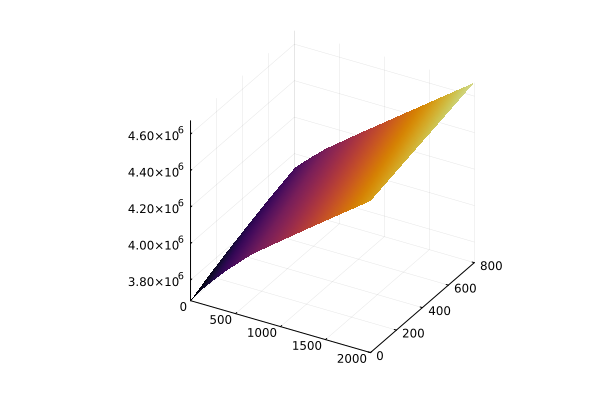

In [23]:
bounds_1 = LinRange(0.0, R[1].currentvolume, 100)
bounds_2 = LinRange(0.0, R[2].currentvolume, 100)
println(bounds_1, bounds_2)
println(R[1], R[2])
f(x, y) = SDDP.evaluate(V_data, (Symbol("l[Holsmjon]") => y, Symbol("l[Flasjon]") => x))[1]
surface(bounds_1, bounds_2, f, legend = false)

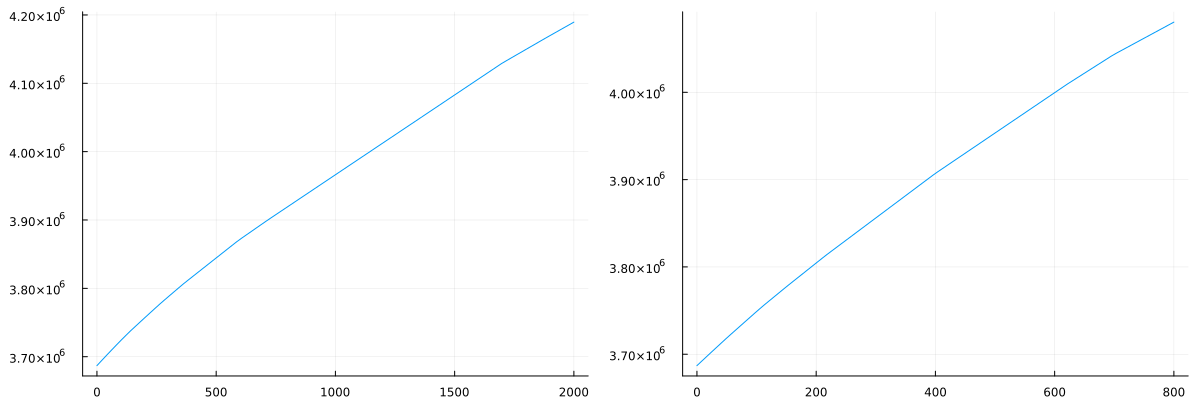

In [39]:
g(x) = SDDP.evaluate(V_data, (Symbol("l[Holsmjon]") => x, Symbol("l[Flasjon]") => 0))[1]
h(x) = SDDP.evaluate(V_data, (Symbol("l[Holsmjon]") => 0, Symbol("l[Flasjon]") => x))[1]

Plots.plot([bounds_1, bounds_2], [g, h], legend=false, layout = (1, 2), size= (1200,400), show=true)

The approach is to generate approximations to the Water Value Function (which is already difficult to define in the first place).

* Solve the medium-term model
* Obtain dual solution $\pi_r$ corresponding to the balance constraints of the reservoirs -> Gradient for Water Value
* Obtain objective function value $\varphi_M(l)$
* Form the cut coefficients for each cut $c$ from both informations for different reservoir levels.

Mathematically speaking, we are trying to find cuts of the following form:

$$
\alpha^c \leq \varphi_M^c(l) - \sum\limits_{r \in \mathbb{R}} \pi_r^c \cdot (l_{r}^c - l_{r,t+1})
$$

And the Water Value Function is the minimum of piecewise linear functions then:
$$
V(r) \leq \min_{c \in \mathcal{C}} \{   \}
$$
From SDDP.ValueFunction we can derive the objective function as well as the gradient at that point in space:

In [25]:
V_data = SDDP.ValueFunction(model_data; node = 1)
cuts = 10

ReservoirValues = Dict( r => collect(range(0, r.maxvolume, length=cuts))  for r in R)
objvalues = [SDDP.evaluate(V_data, Dict(Symbol("l[$(r)]") => ReservoirValues[r][c] for r in R))[1] for c in 1:cuts]
gradients = [SDDP.evaluate(V_data, Dict(Symbol("l[$(r)]") => ReservoirValues[r][c] for r in R))[2] for c in 1:cuts]
println(ReservoirValues)
println("Objective value: ", objvalues)
println("Gradient at reservoir level: ", gradients)
println("A Water Value Cut looks like this (Flasjon): \n ________________________________")
for c in 1:cuts
    println("a <= $(objvalues[c]) -  $(gradients[c][Symbol("l[$(R[1])]")]) *($(ReservoirValues[R[1]][c]) - $(R[1].currentvolume/2)) - $(gradients[c][Symbol("l[$(R[2])]")]) * ($(ReservoirValues[R[2]][c]) - $(R[2].currentvolume/2))) ")
    println("... = ", (objvalues[c]) -  gradients[c][Symbol("l[$(R[1])]")] *(ReservoirValues[R[1]][c] - R[1].currentvolume/2) - gradients[c][Symbol("l[$(R[2])]")] * (ReservoirValues[R[2]][c] - R[2].currentvolume/2))
    println()
end

Dict{Reservoir, Vector{Float64}}(Holsmjon => [0.0, 213.33333333333334, 426.6666666666667, 640.0, 853.3333333333334, 1066.6666666666667, 1280.0, 1493.3333333333333, 1706.6666666666667, 1920.0], Flasjon => [0.0, 444.44444444444446, 888.8888888888889, 1333.3333333333333, 1777.7777777777778, 2222.222222222222, 2666.6666666666665, 3111.1111111111113, 3555.5555555555557, 4000.0])
Objective value: [3.6869489566186327e6, 3.9821897918109028e6, 4.199694240226316e6, 4.402441283743944e6, 4.604202505305687e6, 4.804708213263474e6, 5.003827344147443e6, 5.200451533722143e6, 5.397075723296842e6, 5.593699912871541e6]
Gradient at reservoir level: 

[Dict(Symbol("l[Holsmjon]") => 379.1978796748827, Symbol("l[Flasjon]") => 644.6042712261066), Dict(Symbol("l[Holsmjon]") => 231.98504651425824, Symbol("l[Flasjon]") => 434.0658996971931), Dict(Symbol("l[Holsmjon]") => 202.6150929041231, Symbol("l[Flasjon]") => 368.43240254207393), Dict(Symbol("l[Holsmjon]") => 196.73171980730208, Symbol("l[Flasjon]") => 360.31173361809493), Dict(Symbol("l[Holsmjon]") => 194.9409573743279, Symbol("l[Flasjon]") => 357.56618336534405), Dict(Symbol("l[Holsmjon]") => 194.9409573743279, Symbol("l[Flasjon]") => 357.56618336534405), Dict(Symbol("l[Holsmjon]") => 191.01385931732628, Symbol("l[Flasjon]") => 350.71777407075757), Dict(Symbol("l[Holsmjon]") => 191.01385931732628, Symbol("l[Flasjon]") => 350.71777407075757), Dict(Symbol("l[Holsmjon]") => 191.01385931732628, Symbol("l[Flasjon]") => 350.71777407075757), Dict(Symbol("l[Holsmjon]") => 191.01385931732628, Symbol("l[Flasjon]") => 350.71777407075757)]
A Water Value Cut looks like this (Flasjon): 
 ________

### Print Water Value Function Cuts (Linear Function)

We let the final reservoir level (in this case the current reservoir level is used) vary, to see where the water value cuts are tight

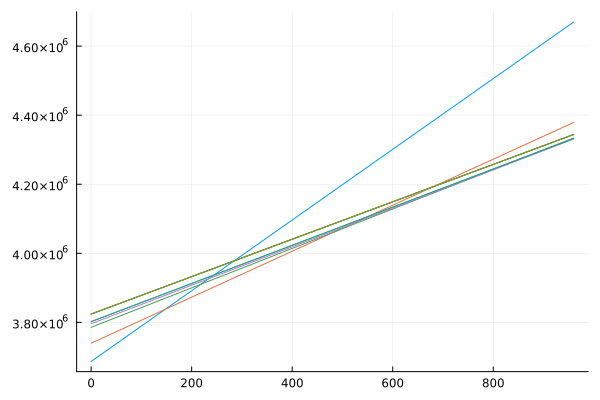

In [35]:
c = 1
WV(x, c) = objvalues[c]  -  gradients[c][Symbol("l[$(R[1])]")] *(ReservoirValues[R[1]][c] - x) - gradients[c][Symbol("l[$(R[2])]")] * (ReservoirValues[R[2]][c] - x)

Plots.plot(LinRange(0.0, R[2].maxvolume/2, 100), 
    [x -> objvalues[c]  -  gradients[c][Symbol("l[$(R[1])]")] *(ReservoirValues[R[1]][c] - x) - gradients[c][Symbol("l[$(R[2])]")] * (ReservoirValues[R[2]][c] - x) for c in 1:cuts],
    legend=false, )

The water value of the upper reservoir is higher, as more power plants can profit from the water flowing from this reservoir.  
This is most likely different, if we look at the Water Value Function of the Individual Producers.

In [27]:
"""

WaterValueCuts(R, ReservoirValues, objvalues, gradients, cuts)


For different reservoir levels, we can derive the objective value and gradient of the objective.
Through Rearranging, we can get the water value function cut coefficients of the linear functions.
We already have the slope (gradient, so we only need to find out the y-coordinate.) We take the current function value, and subtract the gradient * current x value.

Return: Dictionary of reservoirs with two Arrays of Water Value cut coefficients: First is the y-coordinate, second is the gradient.
"""
function WaterValueCuts(R::Vector{Reservoir}, V::SDDP.ValueFunction, cuts::Int64)
    ReservoirWaterValueCuts = Dict(r => (e1 = [],  e2 = []) for r in R)
    ReservoirValues = Dict( r => collect(range(0, r.maxvolume, length=cuts)) for r in R)
    objvalues = [SDDP.evaluate(V, Dict(Symbol("l[$(r)]") => ReservoirValues[r][c] for r in R))[1] for c in 1:cuts]
    gradients = [SDDP.evaluate(V, Dict(Symbol("l[$(r)]") => ReservoirValues[r][c] for r in R))[2] for c in 1:cuts]
    for r in R
        e1::Vector{Float64} = []
        e2::Vector{Float64} = []
        for c in 1:cuts
            push!(e1, objvales[c])
            push!(e2, gradients[c][Symbol("l[$(r)]")])
        end
    end
    return ReservoirWaterValueCuts
end

WaterValueCuts